## Class activation mapping

Based on the paper: <i>Learning Deep Features for Discriminative Localization</i>.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Reshape,Activation
from tensorflow.keras.layers import Conv2D,Flatten,RepeatVector,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,..,3
y_train = y_train[y_train <= 3]
x_train = np.expand_dims(x_train,axis=-1)
x_train,y_train = x_train[:24600],y_train[:24600]
x_train.shape,y_train.shape

((24600, 28, 28, 1), (24600,))

In [3]:
x_train = x_train/255 # scaling the images

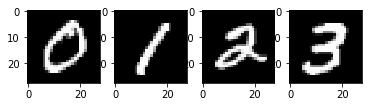

In [4]:
plt.subplot(1,4,1)
plt.imshow(x_train[0][:,:,0],cmap="gray")
plt.subplot(1,4,2)
plt.imshow(x_train[1][:,:,0],cmap="gray")
plt.subplot(1,4,3)
plt.imshow(x_train[2][:,:,0],cmap="gray")
plt.subplot(1,4,4)
plt.imshow(x_train[4][:,:,0],cmap="gray")
plt.show()

In [5]:
def get_model():
    """ Fully-convolutional CNN
    """
    x = Input(shape=(28,28,1))
    h = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation='relu')(x) # 14x14x32
    h = Conv2D(filters=16,kernel_size=3,strides=2,padding='same',activation='relu')(h) # 7x7x16
    h = GlobalAveragePooling2D()(h) # nx8
    h = Dense(4,use_bias=False,activation=None)(h)
    h = Activation('softmax')(h)
    
    model = Model(inputs=x,outputs=h)
    model.compile(loss=SparseCategoricalCrossentropy(),optimizer=Adam(lr=0.01))
    return model

In [6]:
model = get_model()

In [7]:
batch_size=50
epochs=5

for epoch_i in range(epochs):
    losses = []
    for i in range(0,len(x_train),batch_size):
        x_train_subset = x_train[i:i+batch_size]
        y_train_subset = y_train[i:i+batch_size]
        batch_loss = model.train_on_batch(x_train_subset,y_train_subset)
        losses.append(float(batch_loss))
        
    print("Epoch {}: {}".format(epoch_i+1,round(sum(losses)/len(losses),6)))

Epoch 1: 0.547373
Epoch 2: 0.252558
Epoch 3: 0.183203
Epoch 4: 0.147796
Epoch 5: 0.124751


In [8]:
gap_w = model.trainable_variables[-1].numpy()
model_gap = Model(inputs=model.layers[0].input,outputs=model.layers[-4].output)

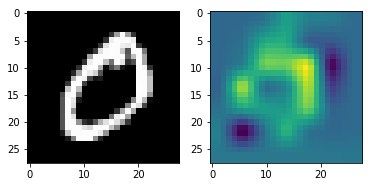

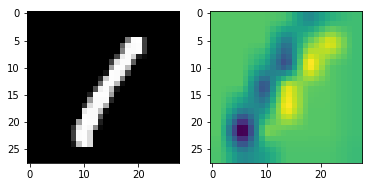

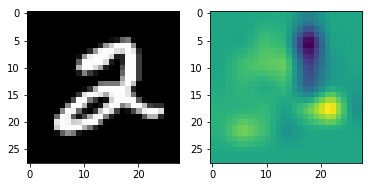

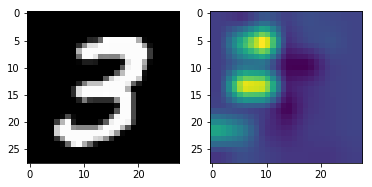

In [9]:
for j,i in enumerate([0,1,2,4]):
    x_ = np.expand_dims(x_train[i][:,:,:],axis=0)
    x_ = model_gap(x_).numpy()
    heatmap = x_.dot(gap_w[:,j])[0]
    heatmap = cv2.resize(heatmap,(28,28))
    plt.subplot(1,2,1)
    plt.imshow(x_train[i][:,:,0],cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(heatmap)
    plt.show()